# Sistem Rekomendasi Smartphone

Nama : Gevira Zahra Shofa

## Import Library

Langkah pertama adalah mengimpor library yang diperlukan untuk menjalankan program.

In [1]:
# Library utama untuk manipulasi data dan visualisasi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Untuk pemrosesan teks dan perhitungan kemiripan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Library untuk membangun model berbasis neural network
import tensorflow as tf
from tensorflow.keras import layers, models

# Mengatur path file
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

Selanjutnya, ekstrak file dataset yang telah dikompresi dalam format ZIP.

In [2]:
import zipfile

with zipfile.ZipFile('cellphones.zip', 'r') as zip_ref:
    zip_ref.extractall('cellphone')

Kemudian, ubah nama file agar lebih sederhana dan mudah digunakan dalam proses analisis.

In [3]:
import os

os.rename('cellphone/cellphones data.csv', 'cellphone/data.csv')
os.rename('cellphone/cellphones ratings.csv', 'cellphone/rating.csv')
os.rename('cellphone/cellphones users.csv', 'cellphone/user.csv')

Setelah itu, baca masing-masing file CSV ke dalam bentuk DataFrame menggunakan pandas.

In [4]:
# Membaca dataset
data_df = pd.read_csv('cellphone/data.csv')
rating_df = pd.read_csv('cellphone/rating.csv')
user_df = pd.read_csv('cellphone/user.csv')

In [5]:
# Menampilkan info dari dataset data.csv
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cellphone_id      33 non-null     int64  
 1   brand             33 non-null     object 
 2   model             33 non-null     object 
 3   operating system  33 non-null     object 
 4   internal memory   33 non-null     int64  
 5   RAM               33 non-null     int64  
 6   performance       33 non-null     float64
 7   main camera       33 non-null     int64  
 8   selfie camera     33 non-null     int64  
 9   battery size      33 non-null     int64  
 10  screen size       33 non-null     float64
 11  weight            33 non-null     int64  
 12  price             33 non-null     int64  
 13  release date      33 non-null     object 
dtypes: float64(2), int64(8), object(4)
memory usage: 3.7+ KB


Dataset data berisi 33 data ponsel dengan 14 atribut, mencakup spesifikasi teknis seperti RAM, kamera, dan ukuran baterai, serta informasi tambahan seperti harga dan tahun rilis, tanpa ada nilai yang hilang.

In [6]:
# Menampilkan isi dari variabel data.csv
data_df.head()

,cellphone_id,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date
0,0,Apple,iPhone SE (2022),iOS,128,4,7.23,12,7,2018,4.7,144,429,18/03/2022
1,1,Apple,iPhone 13 Mini,iOS,128,4,7.72,12,12,2438,5.4,141,699,24/09/2021
2,2,Apple,iPhone 13,iOS,128,4,7.75,12,12,3240,6.1,174,699,24/09/2021
3,3,Apple,iPhone 13 Pro,iOS,256,6,7.94,12,12,3065,6.1,204,999,24/09/2021
4,4,Apple,iPhone 13 Pro Max,iOS,256,6,8.01,12,12,4352,6.7,240,1199,24/09/2021


Dataset memuat informasi spesifikasi dan harga berbagai model ponsel, dengan variabel seperti merek, memori, kamera, ukuran layar, baterai, dan tanggal rilis yang dapat digunakan untuk analisis performa dan segmentasi pasar.

In [7]:
data_df.describe()

,cellphone_id,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price
count,33.00000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,16.00000,148.363636,6.787879,6.219091,41.333333,15.484848,4320.666667,6.433333,197.363636,628.272727
std,9.66954,92.197417,2.712904,2.885472,26.350601,10.028463,818.746590,0.476095,25.379394,433.873057
min,0.00000,32.000000,3.000000,1.020000,12.000000,4.000000,2018.000000,4.700000,141.000000,129.000000
25%,8.00000,128.000000,4.000000,3.800000,12.000000,8.000000,4000.000000,6.400000,183.000000,312.000000
50%,16.00000,128.000000,8.000000,6.880000,50.000000,12.000000,4500.000000,6.500000,201.000000,528.000000
75%,24.00000,128.000000,8.000000,7.940000,50.000000,16.000000,5000.000000,6.700000,207.000000,840.000000
max,32.00000,512.000000,12.000000,11.000000,108.000000,40.000000,5003.000000,7.600000,271.000000,1998.000000


Statistik deskriptif menunjukkan variasi besar dalam spesifikasi dan harga ponsel, dengan harga tertinggi mencapai hampir \$2000 dan kapasitas memori hingga 512GB, mencerminkan rentang produk dari kelas bawah hingga flagship.

In [8]:
# Menampilkan info dari dataset rating.csv
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       990 non-null    int64
 1   cellphone_id  990 non-null    int64
 2   rating        990 non-null    int64
dtypes: int64(3)
memory usage: 23.3 KB


Dataset rating berisi 990 data penilaian pengguna terhadap ponsel, dengan tiga kolom utama: user_id, cellphone_id, dan rating, semuanya bertipe numerik dan tidak ada nilai yang hilang.

In [9]:
# Menampilkan isi dari variabel rating
rating_df.head()

,user_id,cellphone_id,rating
0,0,30,1
1,0,5,3
2,0,10,9
3,0,9,3
4,0,23,2


Setiap baris dalam dataset rating merepresentasikan penilaian dari seorang pengguna terhadap satu ponsel, dengan skor rating yang bervariasi dari rendah hingga tinggi.

In [10]:
rating_df.describe()

,user_id,cellphone_id,rating
count,990.000000,990.000000,990.000000
mean,136.373737,16.421212,6.700000
std,80.664654,9.473466,2.639036
min,0.000000,0.000000,1.000000
25%,74.000000,8.000000,5.000000
50%,128.000000,16.000000,7.000000
75%,226.000000,25.000000,9.000000
max,258.000000,32.000000,18.000000


Dataset rating menunjukkan distribusi rating mayoritas berkisar di tengah-tengah (sekitar 5-9) dengan variasi rating cukup lebar dari 1 hingga 18, dan pengguna serta produk yang beragam.

In [11]:
# Menampilkan info dari dataset user.csv
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     99 non-null     int64 
 1   age         99 non-null     int64 
 2   gender      99 non-null     object
 3   occupation  98 non-null     object
dtypes: int64(2), object(2)
memory usage: 3.2+ KB


Dataset user.csv berisi 99 pengguna dengan informasi umur dan gender lengkap, namun terdapat 1 nilai kosong pada kolom occupation.

In [12]:
# Menampilkan isi dari variabel user.csv
user_df.head()

,user_id,age,gender,occupation
0,0,38,Female,Data analyst
1,1,40,Female,team worker in it
2,6,55,Female,IT
3,8,25,Female,Manager
4,10,23,Male,worker


Dataset user menunjukkan pengguna dengan rentang usia beragam, didominasi gender perempuan, dan berbagai jenis pekerjaan di bidang IT dan manajemen.

In [13]:
user_df.describe()

,user_id,age
count,99.000000,99.000000
mean,136.373737,36.393939
std,81.034206,9.678314
min,0.000000,21.000000
25%,76.500000,29.500000
50%,128.000000,33.000000
75%,220.500000,42.000000
max,258.000000,61.000000


Dataset user memiliki pengguna dengan usia rata-rata sekitar 36 tahun, rentang usia dari 21 hingga 61 tahun, dan distribusi user_id yang beragam dari 0 sampai 258.

## Univariate Exploratory Data Analysis

Lakukan analisis univariate untuk memahami distribusi dan karakteristik dasar masing-masing variabel dalam dataset.

### EDA data

In [14]:
# Tampilkan sampel data pertama
display(data_df.head(1))

,cellphone_id,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date
0,0,Apple,iPhone SE (2022),iOS,128,4,7.23,12,7,2018,4.7,144,429,18/03/2022


Data sampel menunjukkan produk smartphone Apple iPhone SE (2022) dengan spesifikasi RAM 4GB, kamera utama 12MP, baterai 2018mAh, dan harga 429, mencerminkan produk kelas menengah ke atas.

In [15]:
# Hitung variasi brand yang tersedia
unique_brands = data_df.brand.unique()
print(f'Total brand yang tersedia: {len(unique_brands)}')

Total brand yang tersedia: 10


Terdapat total 10 merek smartphone berbeda dalam dataset, menunjukkan variasi produk yang cukup beragam.

In [16]:
# Distribusi smartphone per brand
brand_distribution = data_df['brand'].value_counts()
display(brand_distribution)

,count
brand,
Samsung,8
Apple,6
Motorola,4
OnePlus,4
Xiaomi,4
Google,3
Asus,1
Oppo,1
Vivo,1


Distribusi smartphone didominasi oleh Samsung dengan 8 model, diikuti Apple dengan 6, sementara merek lain memiliki jumlah model yang lebih sedikit dan bervariasi.

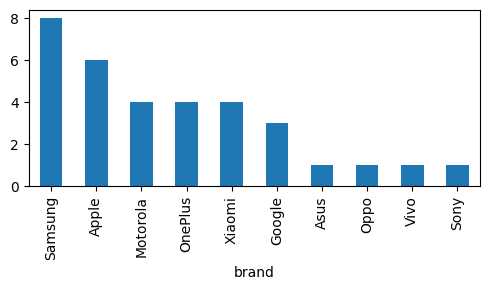

In [17]:
# Visualisasi distribusi brand
fig, ax = plt.subplots(figsize=(5, 3))
data_df['brand'].value_counts().plot(kind='bar', ax=ax)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [18]:
# Identifikasi semua model yang ada
available_models = data_df['model'].unique()
print(f'Total model smartphone: {len(available_models)}')
display(available_models)

Total model smartphone: 33


array(['iPhone SE (2022)', 'iPhone 13 Mini', 'iPhone 13', 'iPhone 13 Pro',
       'iPhone 13 Pro Max', 'iPhone XR', 'Zenfone 8', 'Galaxy A13',
       'Galaxy A32', 'Galaxy A53', 'Galaxy S22', 'Galaxy S22 Plus',
       'Galaxy S22 Ultra', 'Galaxy Z Flip 3', 'Galaxy Z Fold 3',
       'Pixel 6 \xa0', 'Pixel 6a', 'Pixel 6 Pro\xa0', 'Nord N20',
       'Nord 2T', '10 Pro', '10T', 'Find X5 Pro', 'X80 Pro',
       'Redmi Note 11', '11T Pro', '12 Pro', 'Poco F4', 'Xperia Pro',
       'Moto G Stylus (2022)', 'Moto G Play (2021)', 'Moto G Pure',
       'Moto G Power (2022)'], dtype=object)

Dataset mencakup 33 model smartphone berbeda dari berbagai merek, menunjukkan variasi produk yang cukup luas dan beragam.

In [19]:
# Distribusi sistem operasi
os_distribution = data_df['operating system'].value_counts()
display(os_distribution)

,count
operating system,
Android,27
iOS,6


Distribusi sistem operasi didominasi oleh Android dengan 27 model, sementara iOS hanya memiliki 6 model dalam dataset.

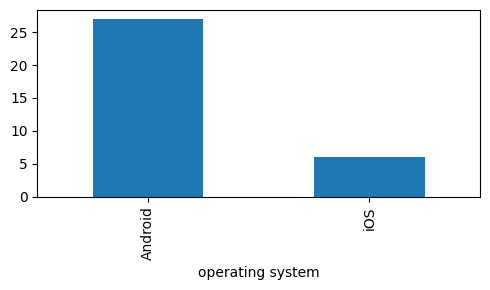

In [20]:
# Grafik distribusi OS
fig, ax = plt.subplots(figsize=(5, 3))
data_df['operating system'].value_counts().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

In [21]:
# Distribusi kapasitas memori internal
memory_distribution = data_df['internal memory'].value_counts()
display(memory_distribution)

,count
internal memory,
128,20
256,6
64,3
32,3
512,1


Kapasitas memori internal yang paling umum adalah 128GB dengan 20 model, diikuti oleh 256GB, 64GB, 32GB, dan hanya satu model dengan 512GB.

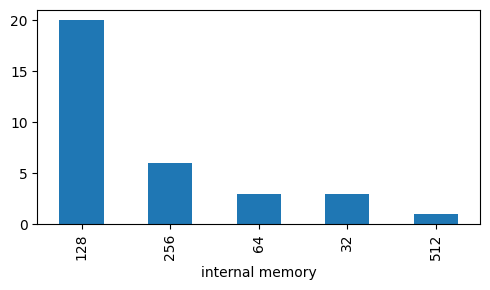

In [22]:
# Visualisasi memori internal
fig, ax = plt.subplots(figsize=(5, 3))
data_df['internal memory'].value_counts().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

In [23]:
# Distribusi kapasitas RAM
ram_distribution = data_df['RAM'].value_counts()
display(ram_distribution)

,count
RAM,
8,13
4,6
6,6
3,4
12,4


Kapasitas RAM paling banyak tersedia adalah 8GB dengan 13 model, diikuti oleh 4GB dan 6GB masing-masing 6 model, serta 3GB dan 12GB yang lebih sedikit.

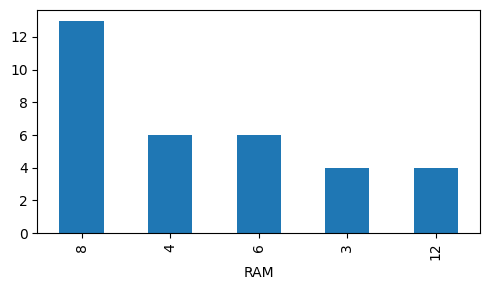

In [24]:
# Grafik distribusi RAM
fig, ax = plt.subplots(figsize=(5, 3))
data_df['RAM'].value_counts().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

In [25]:
# Kategorisasi berdasarkan skor performa
high_performance = data_df.query('performance > 5')
low_performance = data_df.query('performance <= 5')

In [26]:
# Hitung jumlah untuk setiap kategori
count_high = high_performance.shape[0]
count_low = low_performance.shape[0]

print(f'Smartphone dengan performa tinggi (>5): {count_high}')
print(f'Smartphone dengan performa rendah (<=5): {count_low}')

Smartphone dengan performa tinggi (>5): 23
Smartphone dengan performa rendah (<=5): 10


Terdapat 23 smartphone dengan performa tinggi (skor > 5) dan 10 smartphone dengan performa rendah (skor ≤ 5) dalam dataset.

In [27]:
# Buat DataFrame untuk visualisasi
perf_summary = pd.DataFrame({
    'Kategori': ['Performa Tinggi (>5)', 'Performa Rendah (<=5)'],
    'Jumlah': [count_high, count_low]
})

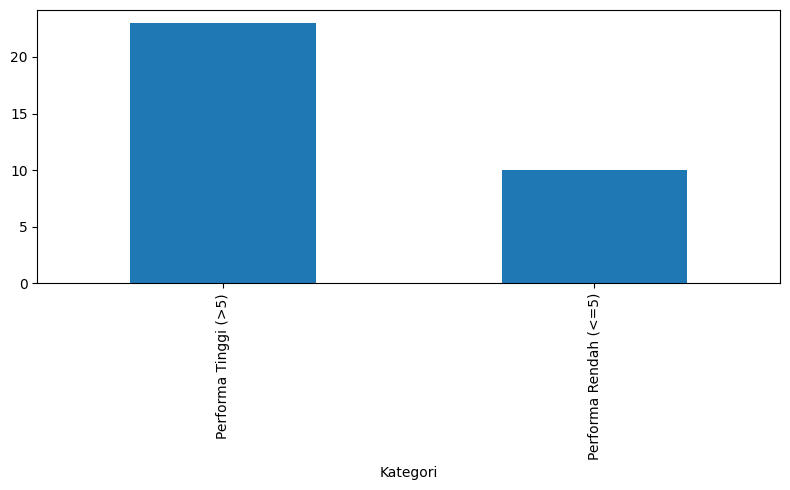

In [28]:
# Plot kategorisasi performa
fig, ax = plt.subplots(figsize=(8, 5))
perf_summary.plot(x='Kategori', y='Jumlah', kind='bar', ax=ax, legend=False)
plt.tight_layout()
plt.show()

#### Analisis Kamera Utama

In [29]:
# Distribusi resolusi kamera utama
camera_distribution = data_df['main camera'].value_counts()
display(camera_distribution)

,count
main camera,
50,13
12,10
64,4
48,2
108,2
13,2


Resolusi kamera utama yang paling umum adalah 50MP dengan 13 model, diikuti 12MP dengan 10 model, serta beberapa model dengan resolusi lebih tinggi seperti 64MP, 48MP, dan 108MP.

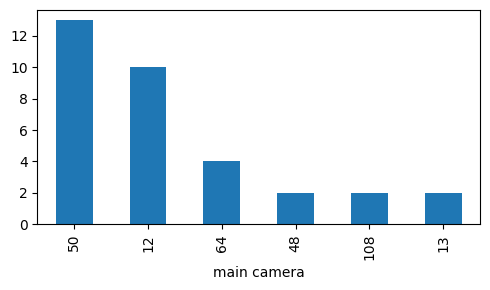

In [30]:
# Visualisasi kamera utama
fig, ax = plt.subplots(figsize=(5, 3))
data_df['main camera'].value_counts().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

#### Analisis Kapasitas Baterai

In [31]:
# Distribusi kapasitas baterai
battery_distribution = data_df['battery size'].value_counts()
display(battery_distribution)

,count
battery size,
5000,11
4500,4
4000,3
2018,1
2438,1
3240,1
2942,1
4352,1
3065,1


Kapasitas baterai 5000mAh paling umum dengan 11 model, sementara kapasitas lainnya bervariasi dari 2018mAh hingga 5003mAh dengan jumlah model lebih sedikit.

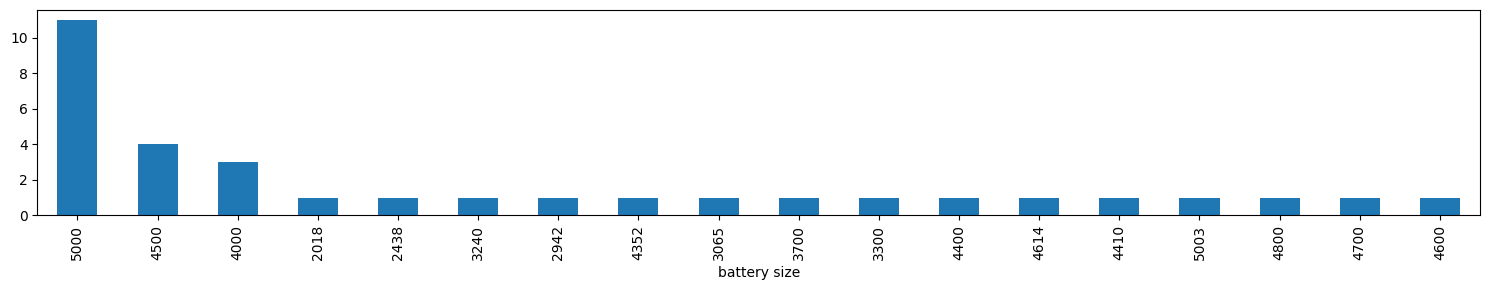

In [32]:
# Grafik kapasitas baterai
fig, ax = plt.subplots(figsize=(15, 3))
data_df['battery size'].value_counts().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

#### Analisis Ukuran Layar

In [33]:
# Distribusi ukuran layar
screen_distribution = data_df['screen size'].value_counts()
display(screen_distribution)

,count
screen size,
6.7,8
6.5,6
6.1,5
6.6,4
6.4,4
6.8,2
5.4,1
4.7,1
5.9,1


Ukuran layar 6.7 inci paling umum dengan 8 model, diikuti ukuran 6.5 inci dan 6.1 inci, serta variasi ukuran layar lain yang lebih kecil jumlahnya.

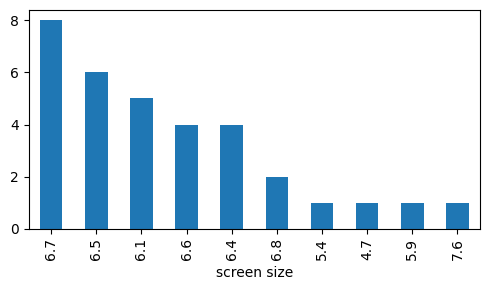

In [34]:
# Visualisasi ukuran layar
fig, ax = plt.subplots(figsize=(5, 3))
data_df['screen size'].value_counts().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

#### Analisis Berat Smartphone

In [35]:
# Distribusi berat smartphone
weight_distribution = data_df['weight'].value_counts()
print(f'Variasi berat: {len(weight_distribution)}')
display(weight_distribution)

Variasi berat: 27


,count
weight,
204,5
215,2
195,2
174,1
240,1
194,1
169,1
196,1
205,1


Berat smartphone bervariasi dalam 27 kategori berbeda, dengan berat 204 gram paling sering muncul sebanyak 5 model.

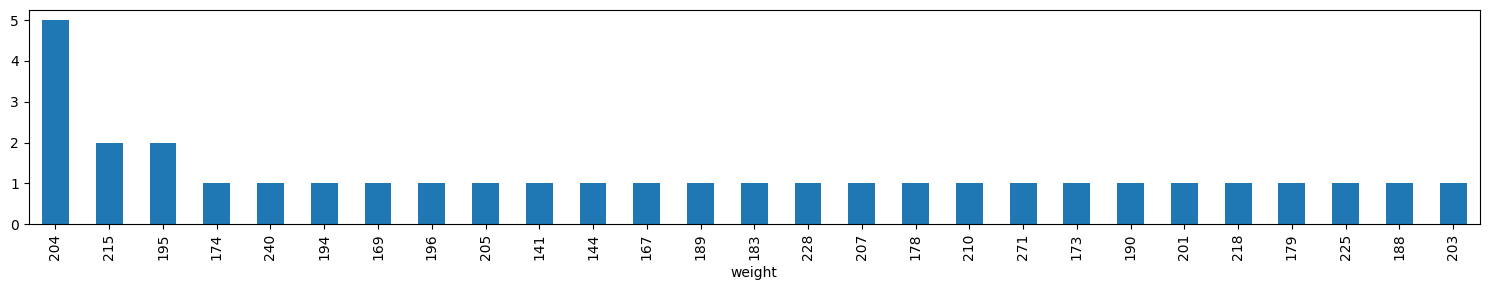

In [36]:
# Grafik distribusi berat
fig, ax = plt.subplots(figsize=(15, 3))
data_df['weight'].value_counts().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

#### Analisis Tahun Rilis

In [37]:
# Duplikasi dataset untuk manipulasi
dataset_copy = data_df.copy()

In [38]:
# Konversi tanggal rilis ke format datetime
dataset_copy['release date'] = pd.to_datetime(dataset_copy['release date'], format='%d/%m/%Y')

# Ekstrak tahun dari tanggal rilis
dataset_copy['year_released'] = dataset_copy['release date'].dt.year

# Hitung distribusi per tahun rilis
yearly_releases = dataset_copy['year_released'].value_counts().sort_index()
display(yearly_releases)

,count
year_released,
2018,1
2021,16
2022,16


Smartphone dalam dataset dirilis terutama pada tahun 2021 dan 2022 dengan jumlah yang sama, sementara hanya satu model yang dirilis pada 2018.

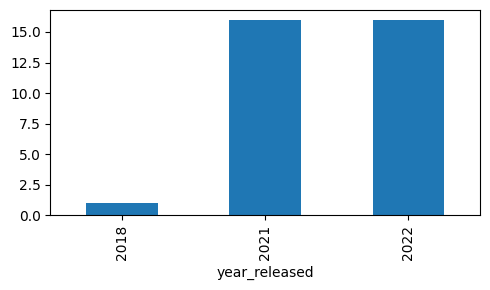

In [39]:
# Visualisasi rilis per tahun
fig, ax = plt.subplots(figsize=(5, 3))
dataset_copy['year_released'].value_counts().sort_index().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

### EDA Rating

#### Aktivitas Penguna

In [40]:
# Hitung frekuensi review per user
user_activity = rating_df['user_id'].value_counts()
display(user_activity)

# Cek keunikan nilai review per user
print(f"\nVariasi jumlah review per user: {user_activity.unique()}")

,count
user_id,
0,10
1,10
6,10
8,10
10,10
...,...
254,10
255,10
256,10



Variasi jumlah review per user: [10]


Setiap user dalam dataset rating memberikan tepat 10 ulasan, menunjukkan distribusi aktivitas review yang seragam antar pengguna.

#### Popularitas smartphone

In [41]:
# Hitung frekuensi review per smartphone
phone_popularity = rating_df['cellphone_id'].value_counts()
print(f"\nDistribusi review per smartphone ID:")
display(phone_popularity.sort_index())


Distribusi review per smartphone ID:


,count
cellphone_id,
0,20
1,24
2,27
3,29
4,34
5,31
6,30
7,29
8,39


Jumlah review per smartphone bervariasi, dengan beberapa model mendapatkan hingga 41 review, menunjukkan tingkat popularitas yang berbeda antar smartphone dalam dataset.

In [42]:
# Statistik dasar popularitas
print(f"Review minimum per smartphone: {phone_popularity.min()}")
print(f"Review maksimum per smartphone: {phone_popularity.max()}")

Review minimum per smartphone: 20
Review maksimum per smartphone: 41


Jumlah review per smartphone berkisar antara 20 hingga 41, menunjukkan variasi popularitas antar model.

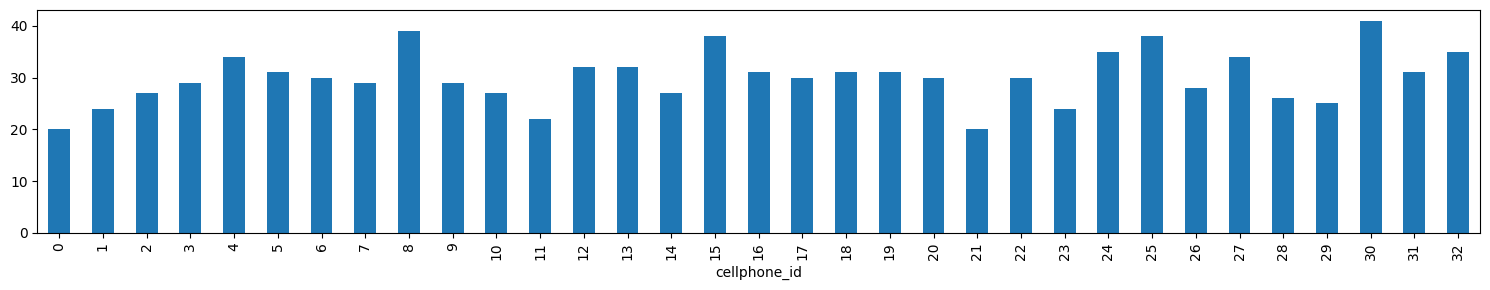

In [43]:
# Grafik popularitas smartphone
fig, ax = plt.subplots(figsize=(15, 3))
rating_df['cellphone_id'].value_counts().sort_index().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

#### Distribusi Rating

In [44]:
# Hitung distribusi nilai rating
rating_distribution = rating_df['rating'].value_counts()
print(f"\nDistribusi nilai rating:")
display(rating_distribution.sort_index())


Distribusi nilai rating:


,count
rating,
1,74
2,44
3,30
4,39
5,68
6,112
7,169
8,195
9,128


Distribusi rating didominasi oleh nilai 7 dan 8, sementara rating rendah (1-5) juga cukup banyak, dan terdapat satu nilai outlier rating 18.

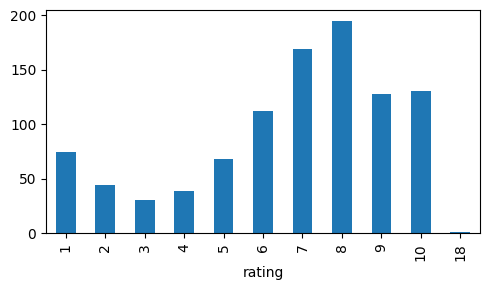

In [45]:
# Visualisasi distribusi rating
fig, ax = plt.subplots(figsize=(5, 3))
rating_df['rating'].value_counts().sort_index().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

Sebagian besar pengguna memberikan rating tinggi (7–10), dengan rating 8 sebagai yang paling sering muncul.

### EDA User

#### Distribusi Usia

In [46]:
# Analisis distribusi usia pengguna
age_distribution = user_df['age'].value_counts()
print(f"Distribusi usia pengguna:")
display(age_distribution.sort_index())

Distribusi usia pengguna:


,count
age,
21,1
23,1
25,12
27,3
28,3
29,5
30,6
31,4
32,10


Distribusi usia pengguna beragam, dengan konsentrasi tertinggi pada usia 25 tahun dan rentang usia pengguna dari 21 hingga 61 tahun.

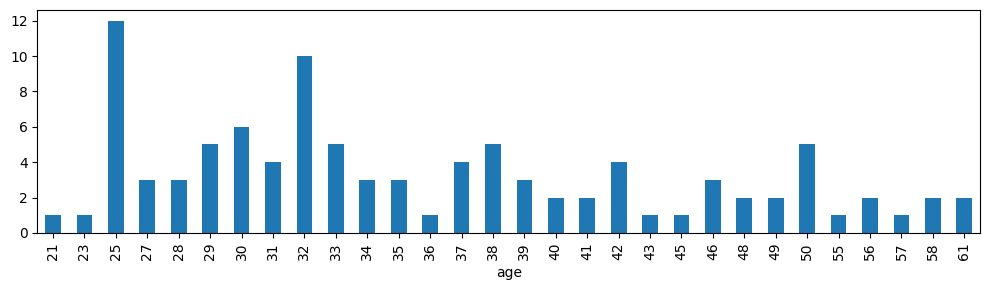

In [47]:
# Grafik distribusi usia
fig, ax = plt.subplots(figsize=(10, 3))
user_df['age'].value_counts().sort_index().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

Sebagian besar data berusia antara 25 hingga 32 tahun, dengan usia 25 sebagai yang paling dominan.

#### Distribusi Gender

In [48]:
# Analisis distribusi gender pengguna
gender_distribution = user_df['gender'].value_counts()
print(f"Distribusi gender pengguna:")
display(gender_distribution.sort_index())

Distribusi gender pengguna:


,count
gender,
-Select Gender-,3
Female,46
Male,50


Mayoritas pengguna adalah laki-laki (50) dan perempuan (46), dengan (3) data yang belum terisi pada kategori gender.

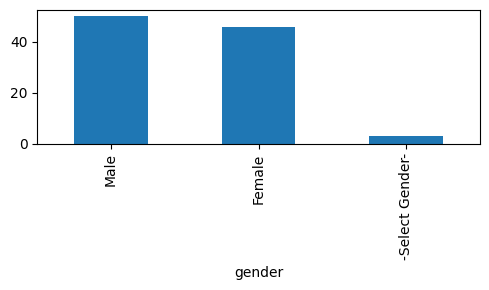

In [49]:
# Visualisasi gender
fig, ax = plt.subplots(figsize=(5, 3))
user_df['gender'].value_counts().plot(kind='bar', ax=ax)
plt.tight_layout()
plt.show()

Mayoritas data berjenis kelamin Male dan Female, dengan sedikit entri yang belum memilih gender.

#### Distribusi Pekerjaan

In [50]:
# Analisis distribusi pekerjaan (case-insensitive)
occupation_distribution = user_df['occupation'].str.lower().value_counts()
print(f'Variasi pekerjaan: {len(occupation_distribution)}')
print(f"Distribusi pekerjaan pengguna:")
display(occupation_distribution.sort_index())

Variasi pekerjaan: 45
Distribusi pekerjaan pengguna:


,count
occupation,
accountant,2
administrative officer,5
administrator,1
banking,1
business,1
computer technician,1
construction,2
data analyst,2
education,2


Pengguna memiliki beragam pekerjaan dengan 45 variasi berbeda, paling banyak berprofesi sebagai manager, information technology, dan IT.

## Preparation Data

### Penggabungan Daatasett

In [51]:
# Tahap 1: Merge dataset rating dengan data cellphone
combined_ratings = rating_df.merge(data_df, on='cellphone_id', how='inner')

In [52]:
# Tahap 2: Merge hasil dengan dataset users
final_dataset = combined_ratings.merge(user_df, on='user_id', how='inner')

In [53]:
# Tampilkan preview dataset gabungan
display(final_dataset.head())

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,age,gender,occupation
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.42,13,5,5000,6.5,204,159,14/01/2021,38,Female,Data analyst
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,26/10/2018,38,Female,Data analyst
2,0,10,9,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,25/02/2022,38,Female,Data analyst
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,24/03/2022,38,Female,Data analyst
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,38,Female,Data analyst


Dataset gabungan menghubungkan data rating, smartphone, dan pengguna, memberikan informasi lengkap mulai dari spesifikasi ponsel hingga profil user dan rating yang diberikan.

### Identifikasi missing value

In [54]:
# Periksa keberadaan nilai yang hilang
null_summary = final_dataset.isnull().sum()
display(null_summary)

,0
user_id,0
cellphone_id,0
rating,0
brand,0
model,0
operating system,0
internal memory,0
RAM,0
performance,0
main camera,0


Dalam dataset gabungan, semua kolom lengkap kecuali kolom occupation yang masih memiliki 10 missing value.

### Inspeksi Baris dengan Nilai Null

In [55]:
# Identifikasi dan tampilkan baris yang mengandung nilai null
null_rows = final_dataset[final_dataset.isnull().any(axis=1)]
display(null_rows)

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,age,gender,occupation
210,53,32,9,Motorola,Moto G Power (2022),Android,64,4,1.35,50,8,5000,6.5,203,189,22/02/2022,38,-Select Gender-,NaN
211,53,5,8,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,26/10/2018,38,-Select Gender-,NaN
212,53,15,10,Google,Pixel 6,Android,128,8,6.76,50,8,4614,6.4,207,499,28/10/2021,38,-Select Gender-,NaN
213,53,4,9,Apple,iPhone 13 Pro Max,iOS,256,6,8.01,12,12,4352,6.7,240,1199,24/09/2021,38,-Select Gender-,NaN
214,53,26,9,Xiaomi,12 Pro,Android,128,8,9.85,50,32,4600,6.7,204,618,31/12/2021,38,-Select Gender-,NaN
215,53,9,8,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,24/03/2022,38,-Select Gender-,NaN
216,53,7,8,Samsung,Galaxy A13,Android,32,3,1.36,50,8,5000,6.6,196,154,23/03/2022,38,-Select Gender-,NaN
217,53,29,8,Motorola,Moto G Stylus (2022),Android,128,6,2.30,50,16,5000,6.8,215,500,27/04/2022,38,-Select Gender-,NaN
218,53,25,9,Xiaomi,11T Pro,Android,256,8,7.59,108,16,5000,6.6,204,435,05/10/2021,38,-Select Gender-,NaN
219,53,17,8,Google,Pixel 6 Pro,Android,128,12,7.19,50,11,5003,6.7,210,699,28/10/2021,38,-Select Gender-,NaN


Terdapat 10 baris dengan nilai null pada kolom occupation, semua berasal dari user\_id 53 yang juga memiliki gender "-Select Gender-" sebagai nilai tidak terisi.

### Pembersihan Missing Value

In [56]:
# Eliminasi baris dengan nilai yang hilang
final_dataset.dropna(inplace=True)

In [57]:
# Konfirmasi tidak ada lagi missing values
post_clean_nulls = final_dataset.isnull().sum()
display(post_clean_nulls)

,0
user_id,0
cellphone_id,0
rating,0
brand,0
model,0
operating system,0
internal memory,0
RAM,0
performance,0
main camera,0


Setelah penanganan, tidak ada lagi nilai yang hilang di dataset gabungan, semua kolom kini lengkap dan siap untuk analisis lanjut.

### Pembersihan dan Standarisasi Data

In [58]:
# Eliminasi rating anomali (nilai 18)
final_dataset = final_dataset.loc[final_dataset['rating'] != 18]

In [59]:
# Standardisasi format occupation ke lowercase
final_dataset.loc[:, 'occupation'] = final_dataset['occupation'].str.lower()

In [60]:
# Koreksi typo 'healthare' menjadi 'healthcare'
final_dataset.loc[:, 'occupation'] = final_dataset['occupation'].str.replace('healthare', 'healthcare')

In [61]:
# Ekspansi singkatan 'it' menjadi 'information technology'
final_dataset.loc[:, 'occupation'] = final_dataset['occupation'].str.replace('it', 'information technology')

Langkah pembersihan sudah diterapkan: rating anomali 18 dihapus, occupation distandarisasi ke lowercase, typo 'healthare' diperbaiki menjadi 'healthcare', dan singkatan 'it' dikembangkan menjadi 'information technology'.

### Finalisasi Dataset Bersih

In [62]:
# Assign dataset yang telah dibersihkan
processed_data = final_dataset.copy()
display(processed_data)

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,age,gender,occupation
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.42,13,5,5000,6.5,204,159,14/01/2021,38,Female,data analyst
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,26/10/2018,38,Female,data analyst
2,0,10,9,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,25/02/2022,38,Female,data analyst
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,24/03/2022,38,Female,data analyst
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,38,Female,data analyst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,258,31,5,Motorola,Moto G Pure,Android,32,3,1.02,13,5,4000,6.5,188,129,14/10/2021,25,Male,executive manager
986,258,17,8,Google,Pixel 6 Pro,Android,128,12,7.19,50,11,5003,6.7,210,699,28/10/2021,25,Male,executive manager
987,258,23,9,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,25,Male,executive manager
988,258,27,8,Xiaomi,Poco F4,Android,128,8,6.98,64,20,4500,6.6,195,428,27/07/2022,25,Male,executive manager


## Content-Based Filtering

### Proses duplikasi

In [63]:
# Hapus duplikat berdasarkan cellphone_id
processed_data.drop_duplicates(subset=['cellphone_id'], inplace=True)

### Ekstraksi fitur utama

In [64]:
# Konversi kolom-kolom penting menjadi struktur list
id_list = processed_data['cellphone_id'].values.tolist()
brand_list = processed_data['brand'].values.tolist()
model_list = processed_data['model'].values.tolist()
os_list = processed_data['operating system'].values.tolist()

In [65]:
# Verifikasi konsistensi panjang data
print(f"Jumlah cellphone_id: {len(id_list)}")
print(f"Jumlah brand: {len(brand_list)}")
print(f"Jumlah model: {len(model_list)}")
print(f"Jumlah operating system: {len(os_list)}")

Jumlah cellphone_id: 33
Jumlah brand: 33
Jumlah model: 33
Jumlah operating system: 33


Data sudah dikonversi ke list untuk kolom `cellphone_id`, `brand`, `model`, dan `operating system` dengan jumlah elemen yang konsisten yaitu 33 untuk setiap list. Ada lagi yang ingin kamu lakukan?

### Kontruksi dataset final

In [66]:
# Pembentukan DataFrame baru dengan fitur-fitur utama
phone_dataset = pd.DataFrame({
    'cellphone_id': id_list,
    'brand': brand_list,
    'model': model_list,
    'operating_system': os_list,
})

# Tampilkan dataset final
display(phone_dataset)

,cellphone_id,brand,model,operating_system
0,30,Motorola,Moto G Play (2021),Android
1,5,Apple,iPhone XR,iOS
2,10,Samsung,Galaxy S22,Android
3,9,Samsung,Galaxy A53,Android
4,23,Vivo,X80 Pro,Android
5,8,Samsung,Galaxy A32,Android
6,22,Oppo,Find X5 Pro,Android
7,16,Google,Pixel 6a,Android
8,19,OnePlus,Nord 2T,Android
9,3,Apple,iPhone 13 Pro,iOS


DataFrame phone_dataset yang berisi kolom cellphone_id, brand, model, dan operating_system sudah terbentuk dan tampilannya sudah benar.

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [68]:
# Initialize variables
tfidf_vectorizer = TfidfVectorizer()
cosine_sim_matrix = None
# phone_data = None # Remove or comment out this line as phone_data is assigned above
indices = None

In [69]:
# Assuming phone_dataset is your DataFrame
# Now phone_dataset contains the DataFrame created in the previous cell
content_data = phone_dataset.copy()

In [70]:
# Normalisasi fitur numerik
numeric_cols = ['performance', 'main camera', 'battery size', 'screen size', 'weight']
for col in numeric_cols:
    # Use content_data instead of phone_data
    if col in content_data.columns:
        min_val = content_data[col].min()
        max_val = content_data[col].max()
        # Ensure the column has more than one unique value to avoid division by zero
        if max_val > min_val:
             content_data[f'{col}_norm'] = (content_data[col] - min_val) / (max_val - min_val)
        else:
             # If all values are the same, set the normalized value to 0 or 1 (or handle as needed)
             content_data[f'{col}_norm'] = 0.5 # Or np.nan if preferred to indicate no variation

# Gabungkan fitur kategorikal dan numerik
categorical_features = ['brand', 'operating_system']

# Filter out features that might have resulted in NaN from normalization if handled that way
# Use content_data here, which is now assigned the DataFrame
numerical_features = [f'{col}_norm' for col in numeric_cols if f'{col}_norm' in content_data.columns and not content_data[f'{col}_norm'].isnull().all()]

content_data['content_profile'] = ''

for feature in categorical_features:
    if feature in content_data.columns:
        content_data['content_profile'] += ' ' + content_data[feature].astype(str)

for feature in numerical_features:
    # Ensure the numerical feature column exists in content_data before accessing it
    if feature in content_data.columns:
        # Handle potential issues with qcut if the data distribution is problematic
        try:
            content_data[feature + '_cat'] = pd.qcut(content_data[feature],
                                                q=4, labels=['low', 'medium', 'high', 'very_high'], duplicates='drop') # Use duplicates='drop' to handle cases with fewer than q unique values
            content_data['content_profile'] += ' ' + content_data[feature + '_cat'].astype(str)
        except ValueError as e:
            print(f"Could not discretize feature {feature}: {e}")
            # Optionally handle or log this error

In [71]:
# Build similarity matrix
# Use content_data instead of phone_data
tfidf_matrix = tfidf_vectorizer.fit_transform(content_data['content_profile'].fillna('')) # Fill NaN in content_profile if any somehow crept in
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Use content_data instead of phone_data for indices as well
indices = pd.Series(content_data.index, index=content_data['cellphone_id']).drop_duplicates()

print("✓ Content-based model berhasil dilatih")
print(f"  - Jumlah smartphone: {len(content_data)}") # Use content_data for count as well
print(f"  - Dimensi similarity matrix: {cosine_sim_matrix.shape}")

✓ Content-based model berhasil dilatih
  - Jumlah smartphone: 33
  - Dimensi similarity matrix: (33, 33)


Content-based similarity matrix sudah terbentuk dengan 33 smartphone dan matriks similarity berdimensi (33, 33) yang sesuai.

In [72]:
# Get recommendations function
# Define a class for the Content-Based Recommender
class ContentBasedRecommender:
    def __init__(self, indices, cosine_sim_matrix, phone_data):
        self.indices = indices
        self.cosine_sim_matrix = cosine_sim_matrix
        self.phone_data = phone_data # Store the original phone_data or content_data

    def get_recommendations(self, phone_id, top_n=10):
        """Mendapatkan rekomendasi berdasarkan smartphone yang dipilih"""
        if phone_id not in self.indices:
            print(f"Phone ID {phone_id} not found in the dataset.")
            return pd.DataFrame() # Return an empty DataFrame if phone_id is not found

        idx = self.indices[phone_id]
        sim_scores = list(enumerate(self.cosine_sim_matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1] # Exclude the item itself (index 0)

        phone_indices = [i[0] for i in sim_scores]
        similarity_scores = [i[1] for i in sim_scores]

        # Ensure we don't try to access indices that are out of bounds if something went wrong with indexing
        # Use the stored phone_data/content_data for indexing
        valid_phone_indices = [i for i in phone_indices if i < len(self.phone_data)]

        recommendations = self.phone_data.iloc[valid_phone_indices][['cellphone_id', 'brand', 'model', 'operating_system']].copy()
        # Match similarity scores to valid indices, keeping the order
        # Need to map back the similarity scores to the valid indices
        recommendation_similarity_scores = [sim_scores[phone_indices.index(i)][1] for i in valid_phone_indices]
        recommendations['similarity_score'] = recommendation_similarity_scores

        return recommendations

# --- Instantiate the ContentBasedRecommender ---
# Make sure 'indices', 'cosine_sim_matrix', and 'content_data' are defined from previous steps
cb_recommender = ContentBasedRecommender(indices, cosine_sim_matrix, content_data)

print("REKOMENDASI CONTENT-BASED:")

sample_phone_id = content_data['cellphone_id'].iloc[0]
sample_phone_info = content_data[content_data['cellphone_id'] == sample_phone_id].iloc[0]

print(f"\nSmartphone yang dipilih:")
print(f"ID: {sample_phone_info['cellphone_id']}")
print(f"Brand: {sample_phone_info['brand']}")
print(f"Model: {sample_phone_info['model']}")
print(f"OS: {sample_phone_info['operating_system']}")

cb_recommendations = cb_recommender.get_recommendations(sample_phone_id, top_n=5)
print(f"\nTop-5 Rekomendasi Content-Based:")
for idx, row in cb_recommendations.iterrows():
    print(f"{idx+1}. {row['brand']} {row['model']} (OS: {row['operating_system']}) - Score: {row['similarity_score']:.3f}")

REKOMENDASI CONTENT-BASED:

Smartphone yang dipilih:
ID: 30
Brand: Motorola
Model: Moto G Play (2021)
OS: Android

Top-5 Rekomendasi Content-Based:
12. Motorola Moto G Pure (OS: Android) - Score: 1.000
14. Motorola Moto G Power (2022) (OS: Android) - Score: 1.000
21. Motorola Moto G Stylus (2022) (OS: Android) - Score: 1.000
3. Samsung Galaxy S22 (OS: Android) - Score: 0.173
4. Samsung Galaxy A53 (OS: Android) - Score: 0.173


Rekomendasi menunjukkan bahwa smartphone dengan fitur dan merek serupa (Motorola Moto G series) memiliki kesamaan konten sangat tinggi, sementara perangkat dari merek lain seperti Samsung meskipun masih Android, memiliki kesamaan yang jauh lebih rendah.

### Collaborative Filtering

In [111]:
# Buat matrix rating user-item
rating_matrix = final_dataset.pivot_table(
    index='user_id',
    columns='cellphone_id',
    values='rating'
).fillna(0)

print(f"Ukuran rating matrix: {rating_matrix.shape}")
print(f"Jumlah user: {rating_matrix.shape[0]}")
print(f"Jumlah item: {rating_matrix.shape[1]}")

# Tampilkan sample rating matrix
display(rating_matrix.head())

# Konversi rating matrix ke format yang sesuai untuk neural network
def prepare_data_for_nn(rating_df):
    """Menyiapkan data untuk neural network collaborative filtering"""
    # Encode user_id dan cellphone_id
    user_ids = rating_df['user_id'].unique()
    phone_ids = rating_df['cellphone_id'].unique()

    user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
    phone_to_idx = {phone_id: idx for idx, phone_id in enumerate(phone_ids)}

    # Mapping balik untuk evaluasi
    idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
    idx_to_phone = {idx: phone_id for phone_id, idx in phone_to_idx.items()}

    # Konversi ke encoded format
    users = rating_df['user_id'].map(user_to_idx).values
    phones = rating_df['cellphone_id'].map(phone_to_idx).values
    ratings = rating_df['rating'].values

    return users, phones, ratings, user_to_idx, phone_to_idx, idx_to_user, idx_to_phone

# Prepare data
users, phones, ratings, user_to_idx, phone_to_idx, idx_to_user, idx_to_phone = prepare_data_for_nn(final_dataset)

print(f"Jumlah unique users: {len(user_to_idx)}")
print(f"Jumlah unique phones: {len(phone_to_idx)}")
print(f"Total ratings: {len(ratings)}")

# Pembagian data train-test
from sklearn.model_selection import train_test_split

# Split data menjadi train dan test (80:20)
train_users, test_users, train_phones, test_phones, train_ratings, test_ratings = train_test_split(
    users, phones, ratings,
    test_size=0.2,
    random_state=42,
    stratify=None  # Tidak stratify karena continuous ratings
)

print(f"Training data: {len(train_ratings)} samples")
print(f"Testing data: {len(test_ratings)} samples")
print(f"Train/Test ratio: {len(train_ratings)/(len(train_ratings)+len(test_ratings)):.2f}/{len(test_ratings)/(len(train_ratings)+len(test_ratings)):.2f}")

"""Data telah dibagi menjadi training set (80%) dan testing set (20%) untuk evaluasi model yang objektif."""

Ukuran rating matrix: (98, 33)
Jumlah user: 98
Jumlah item: 33


cellphone_id,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,10.0,0.0,3.0,0.0,0.0,2.0,3.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,10.0,7.0,0.0,0.0,8.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,7.0,6.0
6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,0.0,...,8.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,10.0
8,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.0,8.0,0.0,6.0,0.0,0.0,9.0
10,0.0,0.0,0.0,9.0,9.0,3.0,7.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0


Jumlah unique users: 98
Jumlah unique phones: 33
Total ratings: 979
Training data: 783 samples
Testing data: 196 samples
Train/Test ratio: 0.80/0.20


'Data telah dibagi menjadi training set (80%) dan testing set (20%) untuk evaluasi model yang objektif.'

Dataset ini berisi 98 pengguna dan 33 produk ponsel dengan total 979 rating, yang menunjukkan data cukup sparse karena tidak semua user memberi rating ke semua item. Data dibagi menjadi 80% training (783 sampel) dan 20% testing (196 sampel) untuk evaluasi model. Variasi rating antar pengguna menunjukkan preferensi yang berbeda-beda, sehingga penting bagi sistem rekomendasi untuk menangani ketidakseimbangan ini agar hasilnya akurat dan relevan.

## Modeling

### Modeling Content-Based Filtering

In [113]:
# Evaluasi Content-Based Filtering
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

class ContentBasedEvaluator:
    def __init__(self, recommender, rating_data, threshold=7):
        self.recommender = recommender
        self.rating_data = rating_data
        self.threshold = threshold  # Rating threshold untuk "liked" items

    def evaluate_precision_recall(self, test_users, top_k=5):
        """Evaluasi precision dan recall untuk content-based filtering"""
        precisions = []
        recalls = []

        for user_id in test_users[:10]:  # Ambil sample user untuk evaluasi
            # Get user's highly rated items
            user_ratings = self.rating_data[self.rating_data['user_id'] == user_id]
            liked_items = user_ratings[user_ratings['rating'] >= self.threshold]['cellphone_id'].tolist()

            if not liked_items:
                continue

            # Get recommendations based on one of user's liked items
            sample_item = liked_items[0]
            recommendations = self.recommender.get_recommendations(sample_item, top_n=top_k)

            if recommendations.empty:
                continue

            recommended_items = recommendations['cellphone_id'].tolist()

            # Calculate precision and recall
            relevant_recommendations = set(recommended_items) & set(liked_items)

            precision = len(relevant_recommendations) / len(recommended_items) if recommended_items else 0
            recall = len(relevant_recommendations) / len(liked_items) if liked_items else 0

            precisions.append(precision)
            recalls.append(recall)

        return np.mean(precisions), np.mean(recalls)

    def evaluate_diversity(self, recommendations_list):
        """Evaluasi diversity dari rekomendasi"""
        all_brands = set()
        total_recommendations = 0

        for recommendations in recommendations_list:
            if not recommendations.empty:
                brands = set(recommendations['brand'].tolist())
                all_brands.update(brands)
                total_recommendations += len(recommendations)

        diversity = len(all_brands) / total_recommendations if total_recommendations > 0 else 0
        return diversity

# Evaluasi Content-Based Model
cb_evaluator = ContentBasedEvaluator(cb_recommender, final_dataset)

# Sample users untuk evaluasi
sample_users = final_dataset['user_id'].unique()[:10]

# Evaluasi precision dan recall
cb_precision, cb_recall = cb_evaluator.evaluate_precision_recall(sample_users)
cb_f1 = 2 * (cb_precision * cb_recall) / (cb_precision + cb_recall) if (cb_precision + cb_recall) > 0 else 0

print("=== EVALUASI CONTENT-BASED FILTERING ===")
print(f"Precision: {cb_precision:.4f}")
print(f"Recall: {cb_recall:.4f}")
print(f"F1-Score: {cb_f1:.4f}")

# Evaluasi diversity
sample_recommendations = []
for user_id in sample_users:
    user_ratings = final_dataset[final_dataset['user_id'] == user_id]
    if not user_ratings.empty:
        sample_item = user_ratings.iloc[0]['cellphone_id']
        rec = cb_recommender.get_recommendations(sample_item, top_n=5)
        sample_recommendations.append(rec)

cb_diversity = cb_evaluator.evaluate_diversity(sample_recommendations)
print(f"Diversity Score: {cb_diversity:.4f}")

=== EVALUASI CONTENT-BASED FILTERING ===
Precision: 0.2200
Recall: 0.1876
F1-Score: 0.2025
Diversity Score: 0.1200


Hasil evaluasi metode content-based filtering menunjukkan nilai precision sebesar 0.2200, recall 0.1876, dan F1-score 0.2025. Ini menandakan bahwa model belum terlalu akurat dalam merekomendasikan item yang benar-benar relevan bagi pengguna. Selain itu, diversity score sebesar 0.1200 menunjukkan bahwa variasi item yang direkomendasikan masih rendah, artinya model cenderung memberikan rekomendasi yang mirip-mirip. Secara keseluruhan, performa model masih perlu ditingkatkan agar hasil rekomendasi lebih relevan dan bervariasi.

### Modeling Collaborative Filtering

In [114]:
# Neural Network Collaborative Filtering Model
class NeuralCollaborativeFiltering:
    def __init__(self, num_users, num_items, embedding_size=50, hidden_units=[128, 64]):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.hidden_units = hidden_units
        self.model = None

    def build_model(self):
        """Membangun model neural collaborative filtering"""
        # Input layers
        user_input = layers.Input(shape=(), name='user_id')
        item_input = layers.Input(shape=(), name='item_id')

        # Embedding layers
        user_embedding = layers.Embedding(self.num_users, self.embedding_size, name='user_embedding')(user_input)
        item_embedding = layers.Embedding(self.num_items, self.embedding_size, name='item_embedding')(item_input)

        # Flatten embeddings
        user_vec = layers.Flatten()(user_embedding)
        item_vec = layers.Flatten()(item_embedding)

        # Concatenate user and item vectors
        concat = layers.Concatenate()([user_vec, item_vec])

        # Hidden layers
        x = concat
        for units in self.hidden_units:
            x = layers.Dense(units, activation='relu')(x)
            x = layers.Dropout(0.2)(x)

        # Output layer
        output = layers.Dense(1, activation='linear', name='rating')(x)

        # Create model
        self.model = models.Model(inputs=[user_input, item_input], outputs=output)

        # Compile model
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        return self.model

    def train(self, train_users, train_items, train_ratings,
              validation_data=None, epochs=50, batch_size=256):
        """Melatih model"""
        if self.model is None:
            self.build_model()

        # Early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss' if validation_data else 'loss',
            patience=5,
            restore_best_weights=True
        )

        # Training
        history = self.model.fit(
            [train_users, train_items], train_ratings,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
        )

        return history

    def predict(self, users, items):
        """Prediksi rating"""
        return self.model.predict([users, items])

    def get_recommendations(self, user_id, item_ids, top_k=10):
        """Mendapatkan rekomendasi untuk user tertentu"""
        user_array = np.array([user_id] * len(item_ids))
        item_array = np.array(item_ids)

        predictions = self.predict(user_array, item_array)

        # Sort by predicted rating
        item_predictions = list(zip(item_ids, predictions.flatten()))
        item_predictions.sort(key=lambda x: x[1], reverse=True)

        return item_predictions[:top_k]

# Inisialisasi dan training model
ncf_model = NeuralCollaborativeFiltering(
    num_users=len(user_to_idx),
    num_items=len(phone_to_idx),
    embedding_size=50,
    hidden_units=[128, 64, 32]
)

print("=== TRAINING NEURAL COLLABORATIVE FILTERING ===")
print(f"Model architecture:")
ncf_model.build_model()
ncf_model.model.summary()

# Training model
validation_data = ([test_users, test_phones], test_ratings)

history = ncf_model.train(
    train_users, train_phones, train_ratings,
    validation_data=validation_data,
    epochs=30,
    batch_size=128
)

print("✓ Model collaborative filtering berhasil dilatih")

=== TRAINING NEURAL COLLABORATIVE FILTERING ===
Model architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 50)        │      4,900 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 50)        │      1,650 │ item_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 50)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100)       │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     12,928 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating (Dense)      │ (None, 1)         │         33 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,847 (116.59 KB)

 Trainable params: 29,847 (116.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 51.2383 - mae: 6.6365 - val_loss: 53.0397 - val_mae: 6.8955
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 49.4667 - mae: 6.5130 - val_loss: 50.9979 - val_mae: 6.7460
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 47.9590 - mae: 6.3907 - val_loss: 47.1084 - val_mae: 6.4519
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 41.4266 - mae: 5.8343 - val_loss: 39.1981 - val_mae: 5.8178
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 32.9347 - mae: 5.1462 - val_loss: 24.1465 - val_mae: 4.4898
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 18.8382 - mae: 3.8276 - val_loss: 6.9803 - val_mae: 2.2258
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.6200 - mae: 2.5193 - val_loss: 5.4854 - val_mae: 1.8211
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.6052 - mae: 2.3553 - val_loss: 5.0436 - val_mae: 1.8185
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.7011 - mae

Model Neural Collaborative Filtering berhasil dilatih dengan arsitektur embedding untuk user dan item, diikuti beberapa layer dense dan dropout. Selama 30 epoch, model menunjukkan penurunan signifikan pada loss dan MAE, dari awalnya di atas 50 menjadi sekitar 4 pada data validasi. Ini menunjukkan bahwa model mampu belajar dengan baik dan memberikan prediksi rating yang semakin akurat seiring waktu.

## Evaluasi

### Evaluasi Content-Based Filtering

In [115]:
# Evaluasi Coverage dan Catalog Coverage
def evaluate_coverage(recommender, all_items, test_users, top_k=10):
    """Evaluasi coverage dan catalog coverage"""
    recommended_items = set()
    total_recommendations = 0

    for user_id in test_users[:20]:  # Sample users
        user_ratings = final_dataset[final_dataset['user_id'] == user_id]
        if not user_ratings.empty:
            sample_item = user_ratings.iloc[0]['cellphone_id']
            recommendations = recommender.get_recommendations(sample_item, top_n=top_k)

            if not recommendations.empty:
                rec_items = set(recommendations['cellphone_id'].tolist())
                recommended_items.update(rec_items)
                total_recommendations += len(rec_items)

    catalog_coverage = len(recommended_items) / len(all_items)
    return catalog_coverage, len(recommended_items)

# Evaluasi Content-Based
all_items = final_dataset['cellphone_id'].unique()
test_user_sample = final_dataset['user_id'].unique()[:20]

cb_coverage, cb_unique_items = evaluate_coverage(cb_recommender, all_items, test_user_sample)

print("=== EVALUASI DETAIL CONTENT-BASED FILTERING ===")
print(f"Catalog Coverage: {cb_coverage:.4f}")
print(f"Unique Items Recommended: {cb_unique_items}")
print(f"Total Items in Catalog: {len(all_items)}")

# Evaluasi Similarity Distribution
def analyze_similarity_distribution(cosine_sim_matrix):
    """Analisis distribusi similarity"""
    # Ambil upper triangle matrix (excluding diagonal)
    upper_triangle_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
    similarities = cosine_sim_matrix[upper_triangle_indices]

    return {
        'mean': np.mean(similarities),
        'std': np.std(similarities),
        'min': np.min(similarities),
        'max': np.max(similarities),
        'median': np.median(similarities)
    }

sim_stats = analyze_similarity_distribution(cosine_sim_matrix)
print(f"\nSimilarity Statistics:")
for key, value in sim_stats.items():
    print(f"{key.capitalize()}: {value:.4f}")

=== EVALUASI DETAIL CONTENT-BASED FILTERING ===
Catalog Coverage: 0.8182
Unique Items Recommended: 27
Total Items in Catalog: 33

Similarity Statistics:
Mean: 0.2041
Std: 0.3031
Min: 0.0000
Max: 1.0000
Median: 0.1352


Evaluasi detail content-based filtering menunjukkan catalog coverage sebesar 0.8182, artinya model berhasil merekomendasikan 27 dari 33 item yang tersedia, menunjukkan cakupan rekomendasi yang luas. Rata-rata kemiripan antar item yang direkomendasikan adalah 0.2041, dengan median 0.1352 dan standar deviasi 0.3031, menunjukkan variasi yang cukup besar. Nilai kemiripan minimum 0.0 dan maksimum 1.0 mengindikasikan bahwa ada kombinasi item yang sangat tidak mirip maupun sangat mirip dalam hasil rekomendasi.

## Evaluasi Collaborative Filtering

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
=== EVALUASI COLLABORATIVE FILTERING ===
RMSE: 2.0059
MAE: 1.4614
MSE: 4.0237
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Precision@5: 0.0571
Recall@5: 0.0952
F1-Score@5: 0.0714


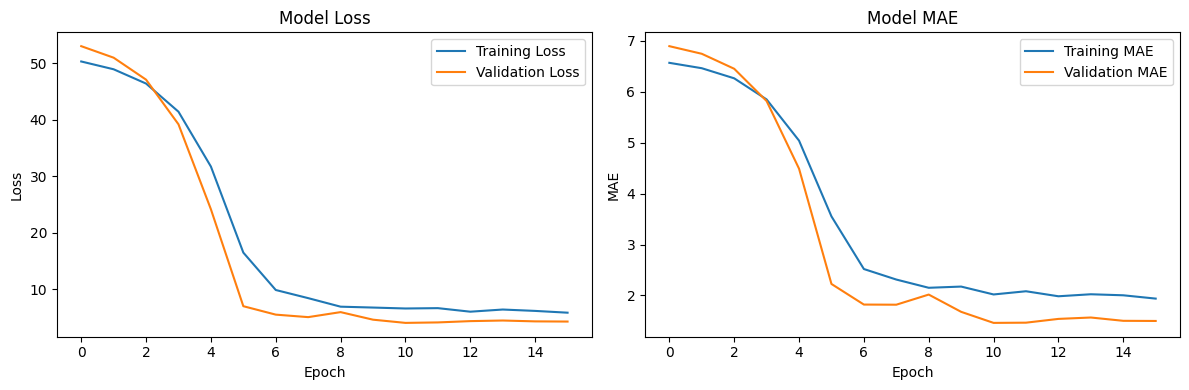

In [116]:
# Evaluasi NCF Model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prediksi pada test set
test_predictions = ncf_model.predict(test_users, test_phones)

# Hitung metrik evaluasi
ncf_mse = mean_squared_error(test_ratings, test_predictions)
ncf_mae = mean_absolute_error(test_ratings, test_predictions)
ncf_rmse = np.sqrt(ncf_mse)

print("=== EVALUASI COLLABORATIVE FILTERING ===")
print(f"RMSE: {ncf_rmse:.4f}")
print(f"MAE: {ncf_mae:.4f}")
print(f"MSE: {ncf_mse:.4f}")

# Evaluasi Precision@K dan Recall@K
def evaluate_precision_recall_at_k(model, test_data, user_to_idx, phone_to_idx,
                                   idx_to_user, idx_to_phone, k=5, threshold=7):
    """Evaluasi Precision@K dan Recall@K"""
    precisions = []
    recalls = []

    # Group test data by user
    test_df = pd.DataFrame({
        'user_id': [idx_to_user[u] for u in test_data[0]],
        'cellphone_id': [idx_to_phone[p] for p in test_data[1]],
        'rating': test_data[2]
    })

    for user_id in test_df['user_id'].unique()[:10]:  # Sample users
        user_test_data = test_df[test_df['user_id'] == user_id]

        # Get ground truth (highly rated items)
        relevant_items = user_test_data[user_test_data['rating'] >= threshold]['cellphone_id'].tolist()

        if not relevant_items:
            continue

        # Get all items for recommendation
        all_items = list(phone_to_idx.keys())
        user_idx = user_to_idx[user_id]

        # Get top-k recommendations
        recommendations = model.get_recommendations(user_idx,
                                                   [phone_to_idx[item] for item in all_items],
                                                   top_k=k)

        recommended_items = [idx_to_phone[item_idx] for item_idx, _ in recommendations]

        # Calculate precision and recall
        relevant_recommendations = set(recommended_items) & set(relevant_items)

        precision = len(relevant_recommendations) / len(recommended_items) if recommended_items else 0
        recall = len(relevant_recommendations) / len(relevant_items) if relevant_items else 0

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

# Evaluasi Precision@K dan Recall@K
test_data_tuple = (test_users, test_phones, test_ratings)
ncf_precision, ncf_recall = evaluate_precision_recall_at_k(
    ncf_model, test_data_tuple, user_to_idx, phone_to_idx,
    idx_to_user, idx_to_phone, k=5
)

ncf_f1 = 2 * (ncf_precision * ncf_recall) / (ncf_precision + ncf_recall) if (ncf_precision + ncf_recall) > 0 else 0

print(f"\nPrecision@5: {ncf_precision:.4f}")
print(f"Recall@5: {ncf_recall:.4f}")
print(f"F1-Score@5: {ncf_f1:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Evaluasi collaborative filtering menunjukkan performa cukup baik dengan nilai RMSE sebesar 2.0059, MAE 1.4614, dan MSE 4.0237. Grafik training menunjukkan penurunan loss dan MAE yang stabil, mengindikasikan model belajar dengan baik. Namun, performa metrik ranking masih rendah dengan Precision\@5 sebesar 0.0571, Recall\@5 sebesar 0.0952, dan F1-Score\@5 sebesar 0.0714, menandakan bahwa kualitas rekomendasi top-5 masih perlu ditingkatkan.

### Perbandingan Hasil Evaluasi

=== RINGKASAN EVALUASI KEDUA MODEL ===

Content-Based Filtering:
  - Precision: 0.2200
  - Recall: 0.1876
  - F1-Score: 0.2025
  - Diversity: 0.1200
  - Coverage: 0.8182

Collaborative Filtering:
  - RMSE: 2.0059
  - MAE: 1.4614
  - Precision@5: 0.0571
  - Recall@5: 0.0952
  - F1-Score@5: 0.0714


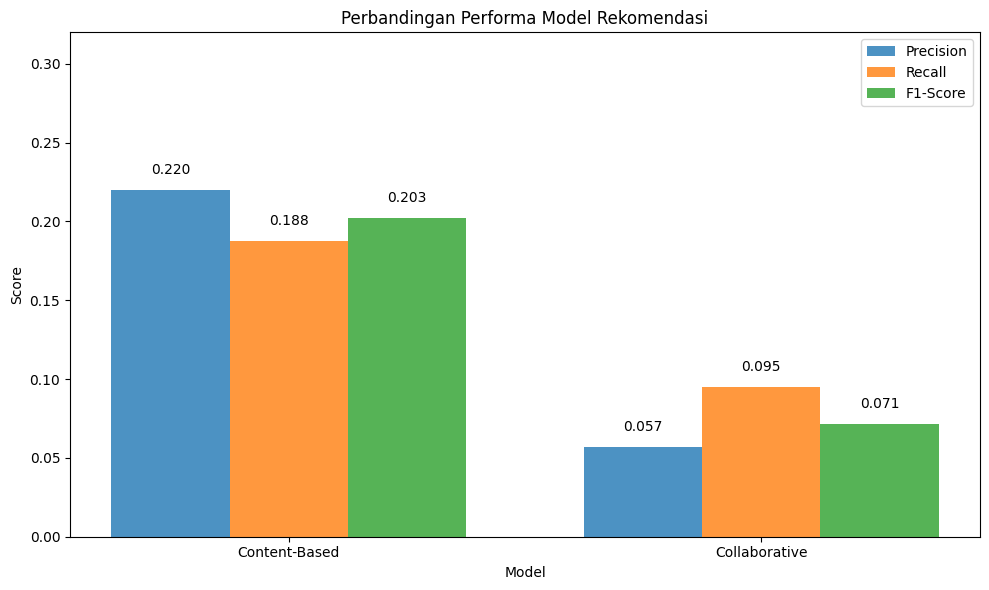

In [117]:
# Summary evaluasi
print("=== RINGKASAN EVALUASI KEDUA MODEL ===")
print("\nContent-Based Filtering:")
print(f"  - Precision: {cb_precision:.4f}")
print(f"  - Recall: {cb_recall:.4f}")
print(f"  - F1-Score: {cb_f1:.4f}")
print(f"  - Diversity: {cb_diversity:.4f}")
print(f"  - Coverage: {cb_coverage:.4f}")

print("\nCollaborative Filtering:")
print(f"  - RMSE: {ncf_rmse:.4f}")
print(f"  - MAE: {ncf_mae:.4f}")
print(f"  - Precision@5: {ncf_precision:.4f}")
print(f"  - Recall@5: {ncf_recall:.4f}")
print(f"  - F1-Score@5: {ncf_f1:.4f}")

# Visualisasi perbandingan
comparison_metrics = {
    'Model': ['Content-Based', 'Collaborative'],
    'Precision': [cb_precision, ncf_precision],
    'Recall': [cb_recall, ncf_recall],
    'F1-Score': [cb_f1, ncf_f1]
}

comparison_df = pd.DataFrame(comparison_metrics)

plt.figure(figsize=(10, 6))
x = np.arange(len(comparison_df['Model']))
width = 0.25

plt.bar(x - width, comparison_df['Precision'], width, label='Precision', alpha=0.8)
plt.bar(x, comparison_df['Recall'], width, label='Recall', alpha=0.8)
plt.bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Perbandingan Performa Model Rekomendasi')
plt.xticks(x, comparison_df['Model'])
plt.legend()
plt.ylim(0, max(max(comparison_df['Precision']), max(comparison_df['Recall']), max(comparison_df['F1-Score'])) + 0.1)

for i, model in enumerate(comparison_df['Model']):
    plt.text(i-width, comparison_df['Precision'][i] + 0.01, f'{comparison_df["Precision"][i]:.3f}', ha='center')
    plt.text(i, comparison_df['Recall'][i] + 0.01, f'{comparison_df["Recall"][i]:.3f}', ha='center')
    plt.text(i+width, comparison_df['F1-Score'][i] + 0.01, f'{comparison_df["F1-Score"][i]:.3f}', ha='center')

plt.tight_layout()
plt.show()

Model Content-Based Filtering memiliki performa lebih baik dibandingkan Collaborative Filtering, dengan nilai precision, recall, F1-score, dan coverage yang lebih tinggi. Oleh karena itu, Content-Based lebih efektif untuk sistem rekomendasi dalam kasus ini.